In [1]:
# !pip install pandas seaborn bokeh

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
%matplotlib inline

figure_size =[20,6]

#plt.rcParams["figure.figsize"] = figure_size  # that's default image size for this interactive session

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
#output_notebook()

In [105]:
invalid = '<>:"/\|?* '

In [4]:
power_threshold = 10000 # [km] LG tarrif

timestamp = 'Timestamp'
power__previous_label = 'Power kW'
power_label = 'Power [kW]'
power_clipped_label = 'Power Clipped [kW]'
peak_label = 'is_peak'
filename = 'ConsommationUniversite.xlsx'

In [5]:
raw = pd.read_excel(filename)
raw = raw.rename(columns={power__previous_label:power_label})
raw['index'] = raw[timestamp].copy()
raw = raw.set_index('index')
raw.head(3)

,Timestamp,Power [kW]
index,,
2015-01-08 00:14:00,2015-01-08 00:14:00,8038.0
2015-01-08 00:29:00,2015-01-08 00:29:00,7880.0
2015-01-08 00:44:00,2015-01-08 00:44:00,7786.0


In [17]:
def year_month_date_to_string(date):
    return date.strftime('%Y%m')

def resample(df, index):
    d = df.set_index(index)
    return d.resample('1T', kind='timestamp').bfill()

def datetime_attributes(df, column, attribute=['year', 'month', 'day', 'hour', 'dayofyear', 'quarter']):
    # define generator expression of series, one for each attribute
    date_gen = (getattr(df[column].dt, i).rename(i) for i in attribute)
    return pd.concat(date_gen, axis=1)

def datetime_isocalendar(df, column, attribute=['year','week', 'weekday']):
    date_gen =  df.apply(lambda x: x[column].isocalendar(), axis=1, result_type='expand')
    return date_gen.rename(columns= dict((i,j) for i,j in enumerate(attribute)) )

#str_month_list = ['Jan','Fev','Mars','Avr','Mai','Juin','Juil','Aout','Sept','Oct','Nov','Déc','Jan','Fev','Mars','Avr','Mai','Juin','Juil','Aout','Sept','Oct','Nov','Déc']

In [18]:
df_time = datetime_attributes(raw,column=timestamp)
df_iso = datetime_isocalendar(raw,column=timestamp)

In [22]:
df = pd.concat([raw, df_time, df_iso[['week','weekday']]],axis=1)
df['year_month'] = year_month_date_to_string(df.index)
df['month_week'] = 100*df['month']+df['week']

df[power_clipped_label] = np.clip(df[power_label],a_min=power_threshold,a_max=None) - power_threshold 
df[peak_label] = np.where(df[power_label]>=power_threshold, 1,0)

df.head(4)

,Timestamp,Power [kW],year,month,day,hour,dayofyear,quarter,week,weekday,year_month,month_week,Power Clipped [kW],is_peak
index,,,,,,,,,,,,,,
2015-01-08 00:14:00,2015-01-08 00:14:00,8038.0,2015,1,8,0,8,1,2,4,201501,102,0.0,0
2015-01-08 00:29:00,2015-01-08 00:29:00,7880.0,2015,1,8,0,8,1,2,4,201501,102,0.0,0
2015-01-08 00:44:00,2015-01-08 00:44:00,7786.0,2015,1,8,0,8,1,2,4,201501,102,0.0,0
2015-01-08 00:59:00,2015-01-08 00:59:00,7914.0,2015,1,8,0,8,1,2,4,201501,102,0.0,0


In [97]:
print (df.year.nunique()*df.month.nunique() )
print(df.info())

24
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69504 entries, 2015-01-08 00:14:00 to 2016-12-31 23:59:00
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Timestamp           69504 non-null  datetime64[ns]
 1   Power [kW]          69504 non-null  float64       
 2   year                69504 non-null  int64         
 3   month               69504 non-null  int64         
 4   day                 69504 non-null  int64         
 5   hour                69504 non-null  int64         
 6   dayofyear           69504 non-null  int64         
 7   quarter             69504 non-null  int64         
 8   week                69504 non-null  int64         
 9   weekday             69504 non-null  int64         
 10  year_month          69504 non-null  object        
 11  month_week          69504 non-null  int64         
 12  Power Clipped [kW]  69504 non-null  float64       
 13  is_peak 

In [101]:
df[[power_label,'year_month']].groupby(by='year_month').describe()

Power [kW]                                                    \
                count         mean          std     min     25%     50%   
year_month                                                                
201501         2304.0  8683.540799  1226.112234  6274.0  7381.5  8916.0   
201502         2688.0  9316.159598  1051.660726  7016.0  8393.5  9810.0   
201503         2976.0  8258.972446  1142.304394  5940.0  7203.0  8494.0   
201504         2880.0  7273.843056  1058.611873  5440.0  6217.5  7335.0   
201505         2976.0  7355.934812  1331.518445  5286.0  6079.5  7358.0   
201506         2880.0  7799.516667  1399.300802  5484.0  6307.5  7956.0   
201507         2976.0  8532.456653  1666.849063  4606.0  6892.0  8741.0   
201508         2976.0  7989.739751  1271.962454  5474.0  6750.0  8174.0   
201509         2880.0  8442.719792  1638.568140  5958.0  6776.0  8439.0   
201510         2976.0  7610.615591  1203.597874  5666.0  6236.0  7819.0   
201511         2880.0  7821.678472  1386.983708  5490.0  6274.0  8176.0   
201512         2976.0  7697.705981  1278.493548  5554.0  6368.0  8002.0   
201601         2976.0  8768.589382  1575.182302  6054.0  7151.5  9061.0   
201602         2784.0  9036.067708  1533.625244  5998.0  7394.0  9405.0   
201603         2976.0  8306.707661  1374.954727  5670.0  6876.5  8547.0   
201604         2880.0  7451.636458  1377.340090  3288.0  6130.0  7751.0   
201605         2976.0  7426.204847  1455.684660  4424.0  5917.5  7608.0   
201606         2880.0  8076.362500  1534.662341  5540.0  6398.0  8416.0   
201607         2976.0  8364.113575  1672.608411  5604.0  6546.0  8600.0   
201608         2976.0  8275.466398  1492.905193  5618.0  6637.5  8611.0   
201609         2880.0  8056.081944  1646.008697  5352.0  6291.5  8176.0   
201610         2976.0  7543.829301  1361.274594  5240.0  6064.0  7739.0   
201611         2880.0  7740.631597  1356.909089  3970.0  6299.0  8031.0   
201612         2976.0  8198.242608  1355.878827  5458.0  7001.0  8081.0   

                              
                75%      max  
year_month                    
201501       9739.0  11488.0  
201502      10006.0  11690.0  
201503       9234.5  10958.0  
201504       8150.5   9954.0  
201505       8346.5  10786.0  
201506       8970.0  11048.0  
201507       9712.5  12168.0  
201508       9010.0  10830.0  
201509       9786.5  12442.0  
201510       8686.5   9906.0  
201511       8998.0  10542.0  
201512       8769.0  10476.0  
201601      10144.5  12414.0  
201602      10292.5  12284.0  
201603       9402.0  11338.0  
201604       8512.0  10798.0  
201605       8464.5  11074.0  
201606       9366.0  11056.0  
201607       9814.5  12232.0  
201608       9444.0  12250.0  
201609       9370.0  12158.0  
201610       8738.5  10574.0  
201611       8906.0  10346.0  
201612       9350.0  11514.0

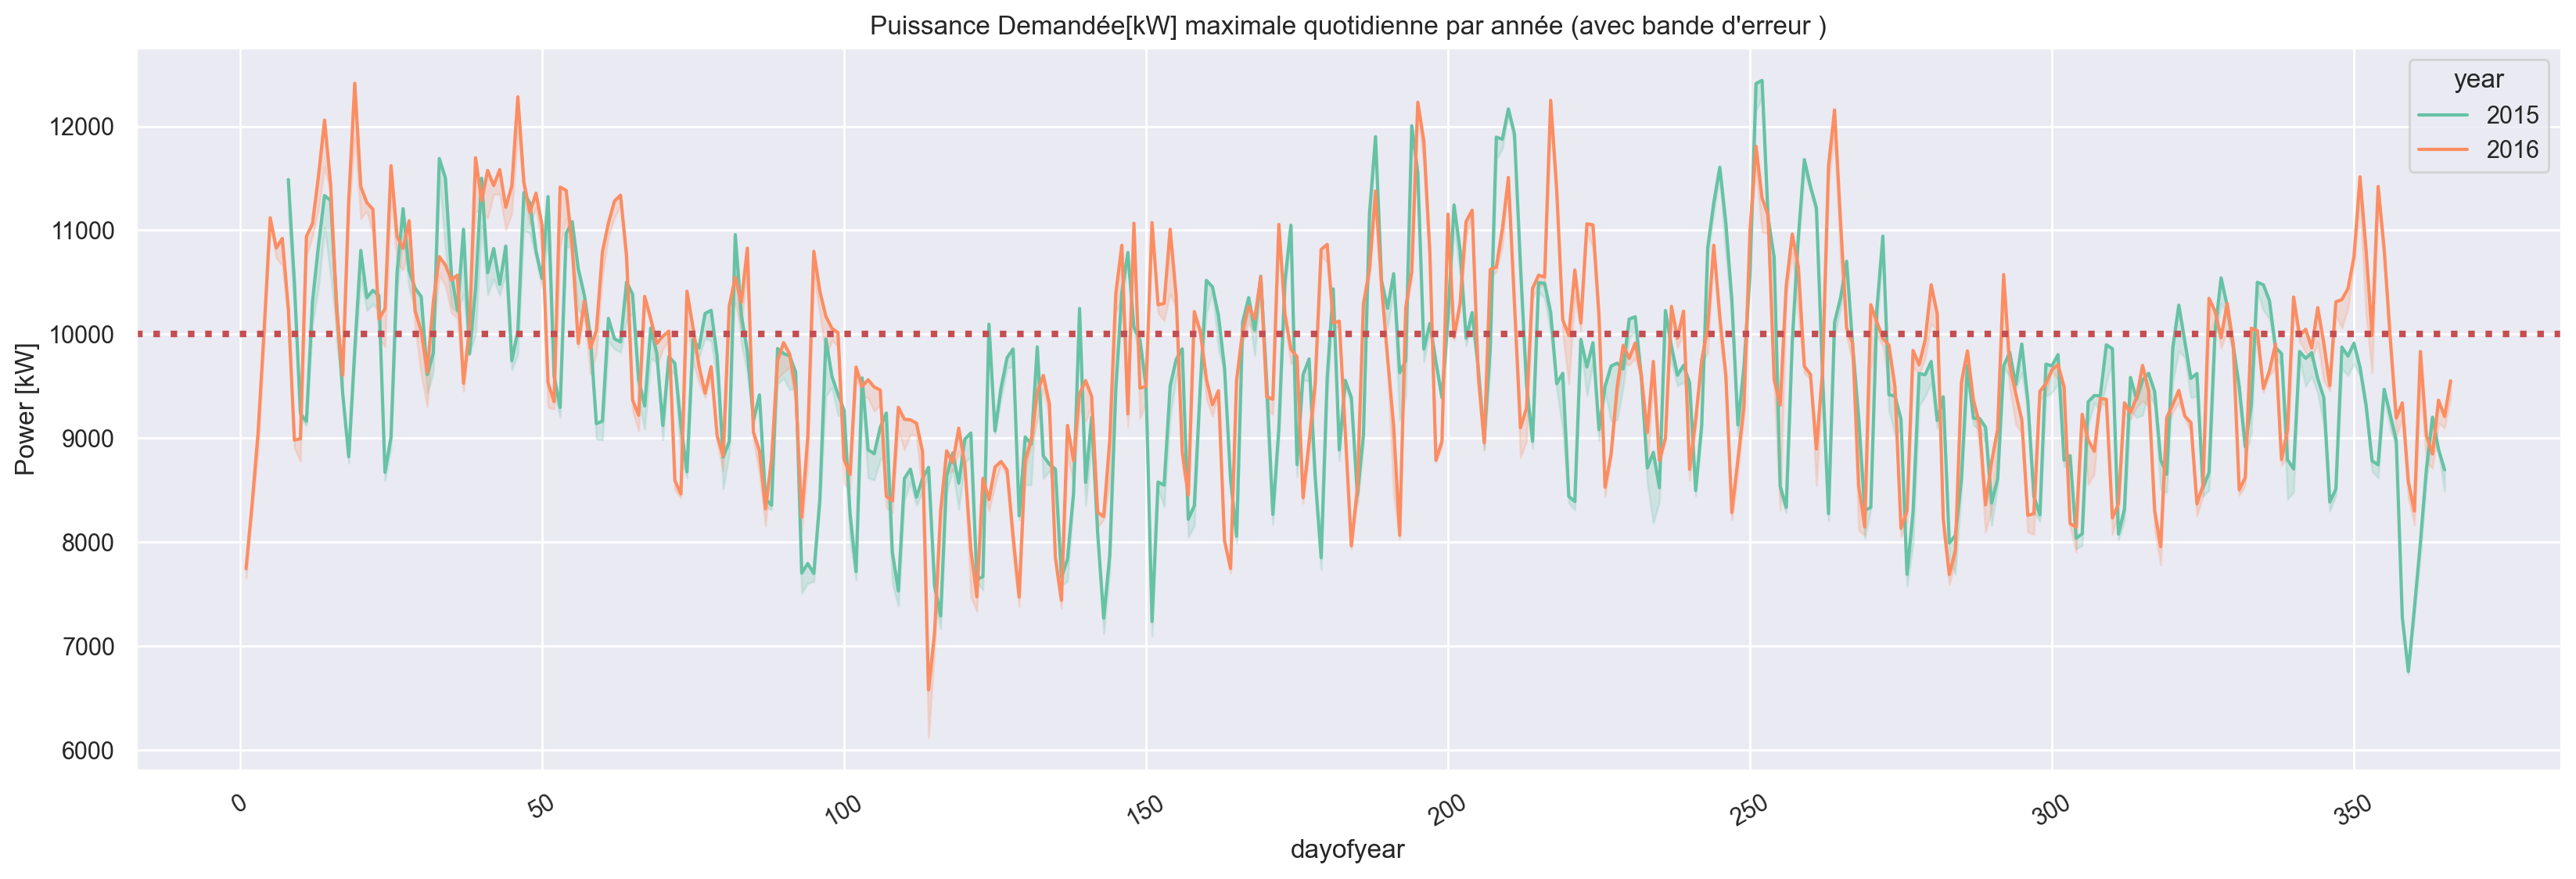

In [108]:
title = "Puissance Demandée[kW] maximale quotidienne par année (avec bande d'erreur )"

sns.set_theme(style="darkgrid")
plt.figure(figsize=figure_size)
# Plot the responses for different events and regions
g = sns.lineplot(x='dayofyear', y=power_label, estimator='max',
             hue="year",data=df, palette='Set2')

# Draw a horizontal line to show the starting point
g.axhline(power_threshold, linestyle=":", color='r', lw=3)
plt.title(title)
plt.xticks(rotation=30);
plt.show()
fig = g.get_figure()
for char in invalid:
	filename = title.replace(char, '_')+'.png'
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


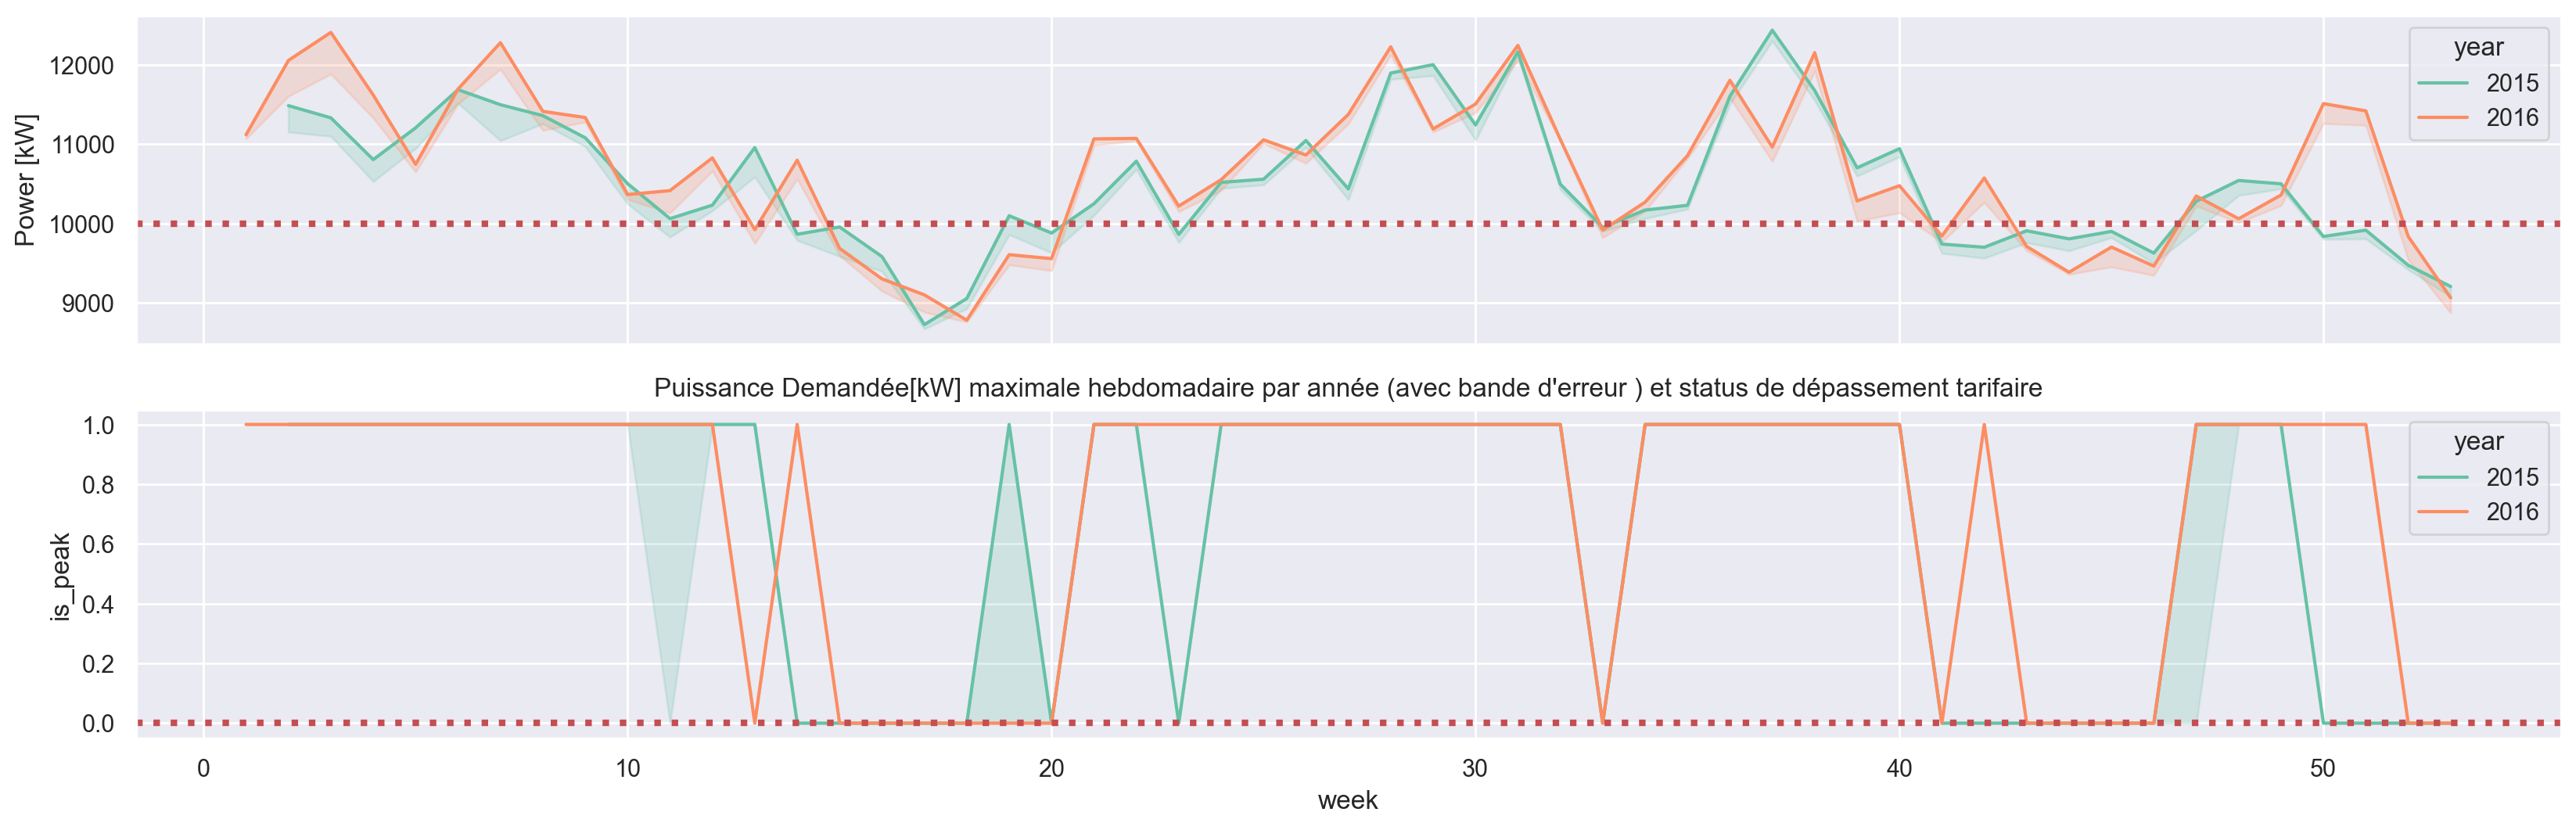

In [123]:
# Error Bands + valeur maximale des mois

title = "Puissance Demandée[kW] maximale hebdomadaire par année (avec bande d'erreur ) et status de dépassement tarifaire"

what= 'week'

#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=2, figsize=figure_size, sharex=True)

# Plot the responses for different events and regions
g = sns.lineplot(x=what, y=power_label, estimator='max',
             hue="year",data=df, palette='Set2', ax=axs[0])

# Draw a horizontal line to show the starting point
g.axhline(power_threshold, linestyle=":", color='r', lw=3)

#----
g = sns.lineplot(x='week', y=peak_label, estimator='max', ax=axs[1],
             hue="year",data=df, palette='Set2')
g.axhline(0, linestyle=":", color='r', lw=3)

#g.fill_between(x, 0, y2)

#fig = g.get_figure()
for char in invalid:
	filename = title.replace(char, '_')+'.png'

    
plt.title(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


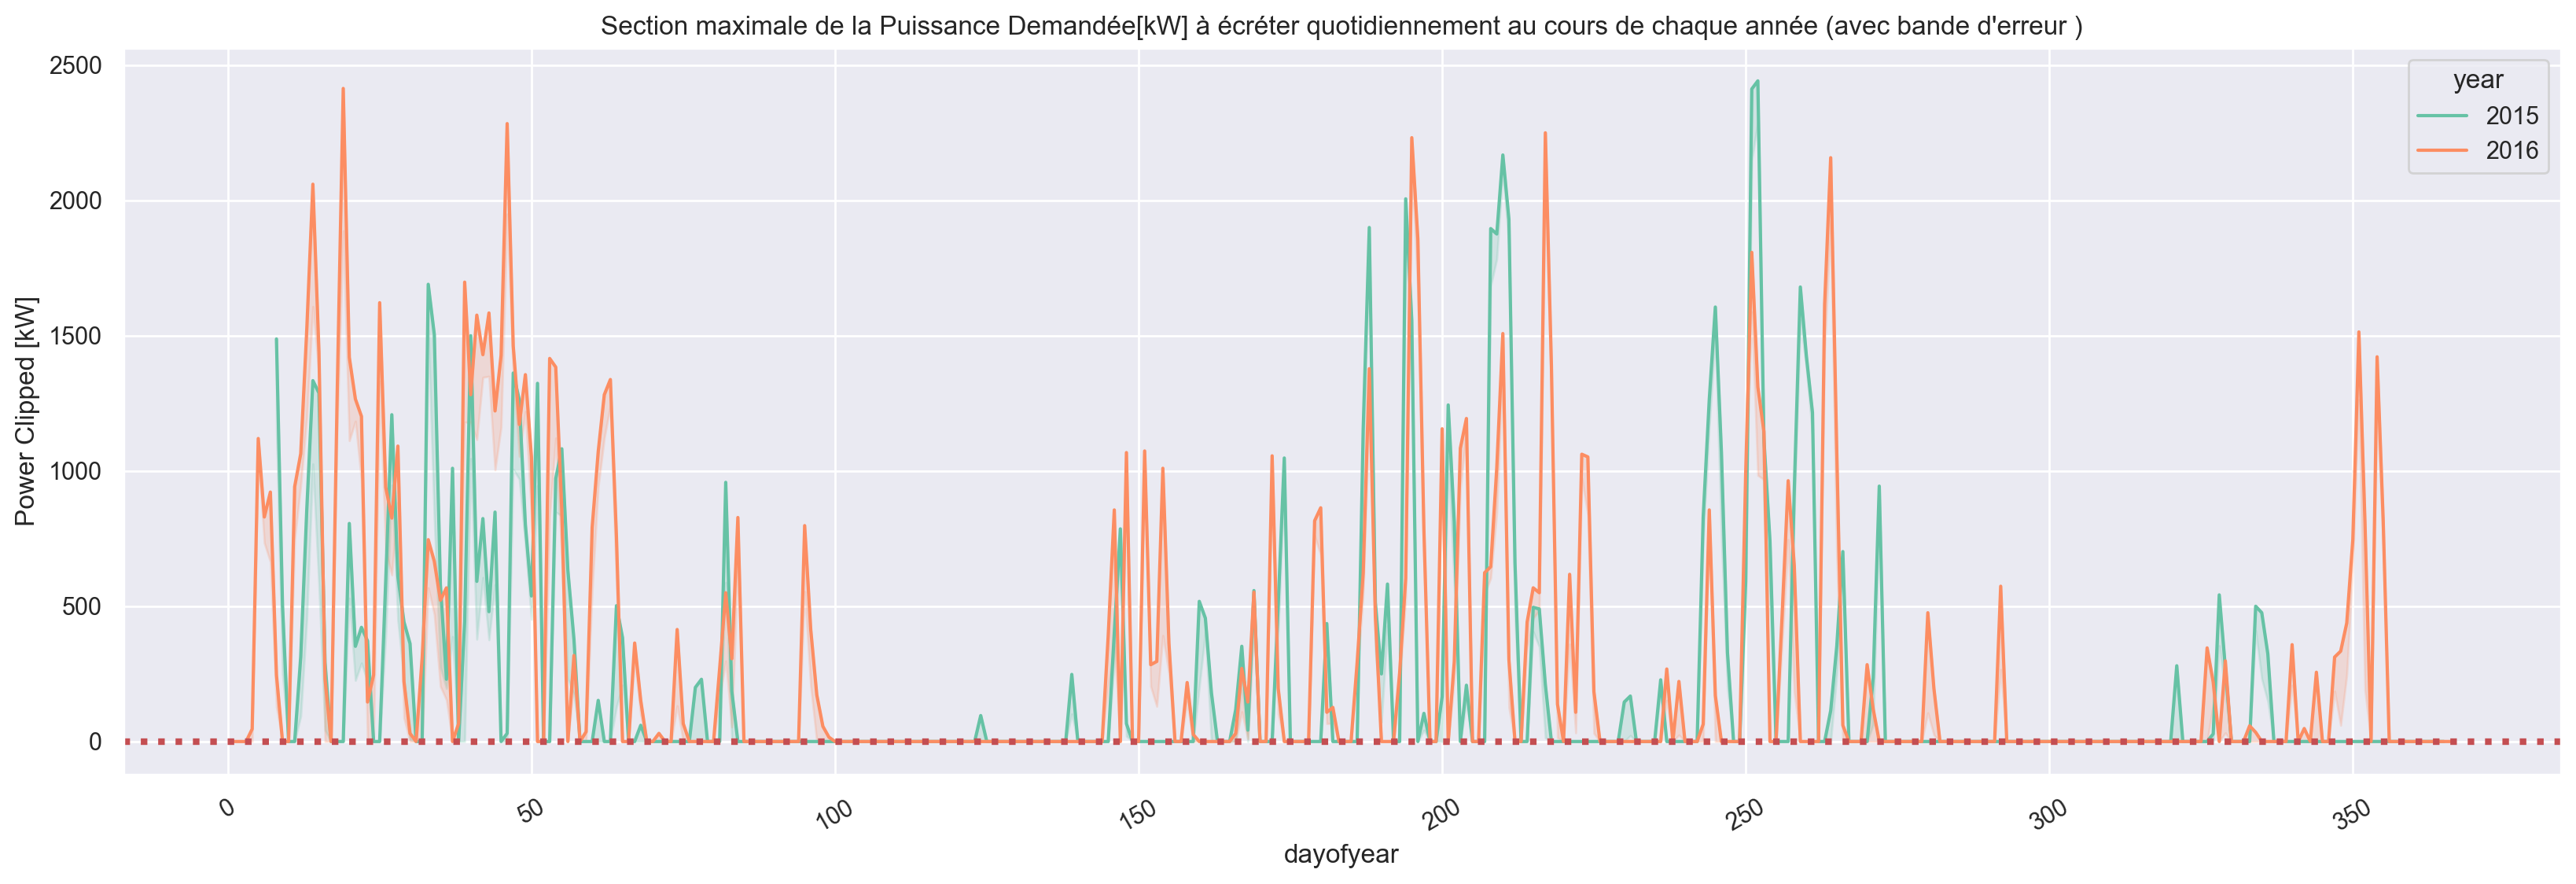

In [124]:
title = "Section maximale de la Puissance Demandée[kW] à écréter quotidiennement au cours de chaque année (avec bande d'erreur )"


sns.set_theme(style="darkgrid")
plt.figure(figsize=figure_size)
# Plot the responses for different events and regions
g = sns.lineplot(x='dayofyear', y=power_clipped_label, estimator='max',
             hue="year",data=df, palette='Set2')

# Draw a horizontal line to show the starting point
g.axhline(0, linestyle=":", color='r', lw=3)

plt.xticks(rotation=30);
plt.title(title)

plt.show()
fig = g.get_figure()
for char in invalid:
	filename = title.replace(char, '_')+'.png'
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2015,12.593985,25.676692,1.766917,0.000000,2.518797,5.676692,22.518797,4.360902,22.255639,0.000000,1.992481,0.639098
2016,20.336972,22.401519,7.214048,0.640721,3.203607,6.359753,15.068818,7.783579,8.448030,0.783104,0.640721,7.119127


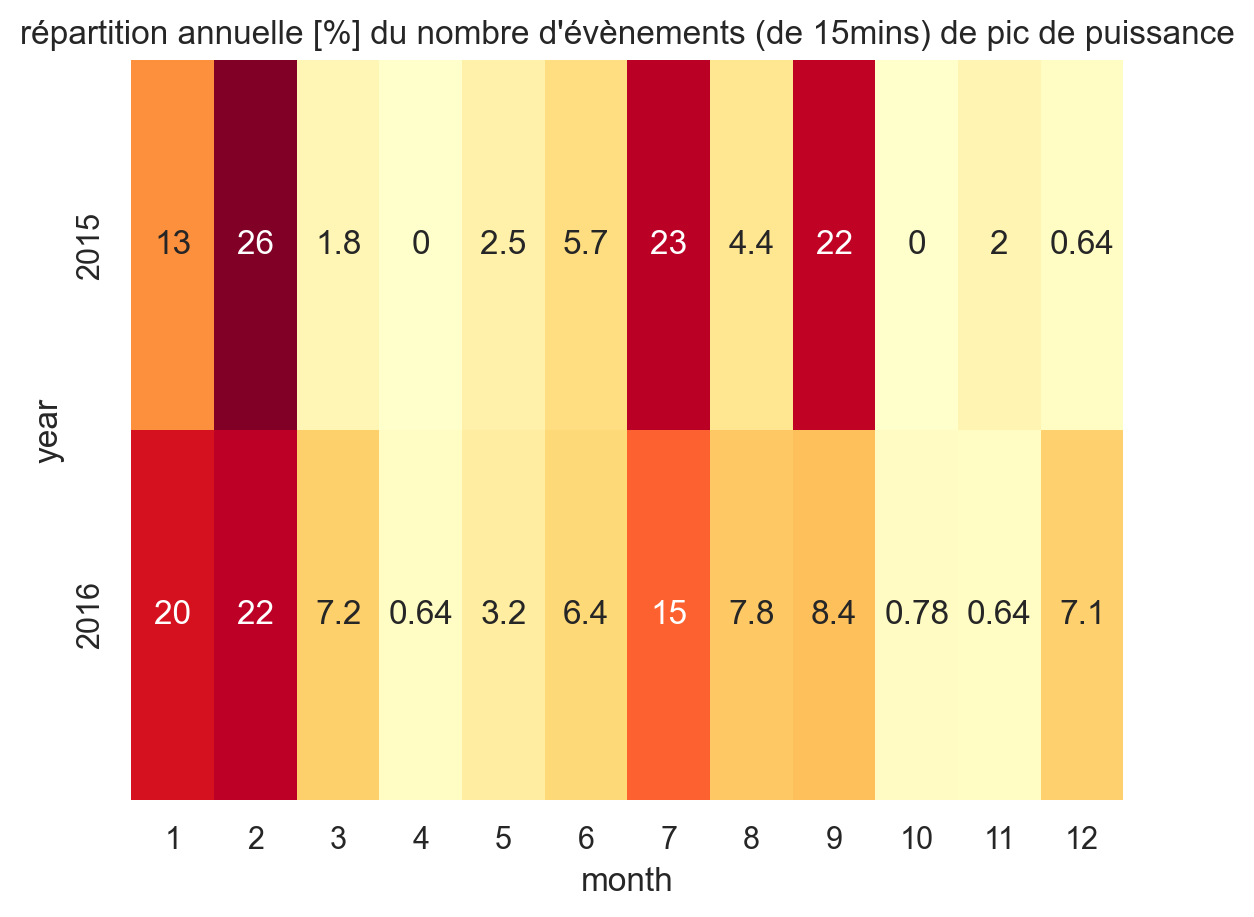

In [126]:
# Pourcentage of Peak per month (over the year)
# Debut d'hiver (chauffage) et Ete(climatisation) == dépense

title = "répartition annuelle [%] du nombre d'évènements (de 15mins) de pic de puissance"

rows = pd.crosstab(df.year, df.month, aggfunc='sum', values=df.is_peak, normalize="index")
rows = 100*rows
display(rows)
g = sns.heatmap(rows,cmap="YlOrRd", annot=True, cbar=False)

plt.title(title)

plt.show()
fig = g.get_figure()
for char in invalid:
	filename = title.replace(char, '_')+'.png'
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')

 TODO: SIGNAL POUR CHANGEMENT HIVER / ETE ?! (VOIR TARIF LG vs PAPIER)

In [94]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=figure_size)
# Plot the responses for different events and regions

#g = sns.FacetGrid(df, col="year", hue="year", palette="Set2",
#                     col_wrap=1, height=1.5, ax=axs[1])
#g.map(sns.barplot,'month', peak_label, estimator='max', ) 



#print(vars(g))


<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

In [48]:
plt.tight_layout()
plt.show()
# save the plot as a file
fig.savefig('power_clipped_and_solar.jpg', format='jpeg', dpi=100, bbox_inches='tight')
#ax.set_xticklabels(dataset.index.year, rotation=90)

# Adjust the tick positions and labels
#g.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
g.fig.tight_layout(w_pad=1)

<Figure size 640x480 with 0 Axes>

AttributeError: 'Axes' object has no attribute 'fig'

In [ ]:
sns.countplot(data=df, x="year_month", hue="is_peak")

In [ ]:
sns.set_theme(style="ticks")

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="month", hue="year", palette="tab20c",
                     col_wrap=4, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=power_threshold, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, timestamp, power_label, marker="o")

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

In [ ]:
# Plot the responses for different events and regions
sns.lineplot(x="dayofyear", y="signal",
             hue="region", style="event",
             data=fmri)


In [ ]:
sns.set_color_codes("pastel")
sns.barplot(x=rows.month, data=rows, color="b")

In [ ]:
vars(rows)

In [ ]:

import numpy as np
import pandas as pd

from bokeh.palettes import tol
from bokeh.plotting import figure, show

N = 10
df = pd.DataFrame(np.random.randint(10, 100, size=(15, N))).add_prefix('y')

p = figure(x_range=(0, len(df)-1), y_range=(0, 800))
p.grid.minor_grid_line_color = '#eeeeee'

names = [f"y{i}" for i in range(N)]
p.varea_stack(stackers=names, x='index', color=tol['Sunset'][N], legend_label=names, source=df)

p.legend.orientation = "horizontal"
p.legend.background_fill_color = "#fafafa"

show(p)